[*********************100%%**********************]  1 of 1 completed
/var/folders/72/xqxvrz7s4n7grqqwprj1mrc80000gn/T/ipykernel_4037/2155444080.py:206: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  elif hasattr(torch, 'has_mps') and torch.backends.mps.is_built():  # Check for MPS availability (Apple Silicon)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: frederik135. Use `wandb login --relogin` to force relogin



  | Name      | Type     | Params
---------------------------------------
0 | model     | RNNModel | 1.8 K 
1 | criterion | MSELoss  | 0     
---------------------------------------
1.8 K     Trainable params
0         Non-trainable params
1.8 K     Total params
0.007     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/anaconda3/envs/masterarbeit/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/opt/anaconda3/envs/masterarbeit/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/opt/anaconda3/envs/masterarbeit/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (48) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
Restoring states from the checkpoint path at ./RNN_single_step_forecasts/oka25w9f/checkpoints/epoch=29-step=1440.ckpt
Loaded model weights from the checkpoint at ./RNN_single_step_forecasts/oka25w9f/checkpoints/epoch=29-step=1440.ckpt
/opt/anaconda3/envs/masterarbeit/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

 
364
364
364
 


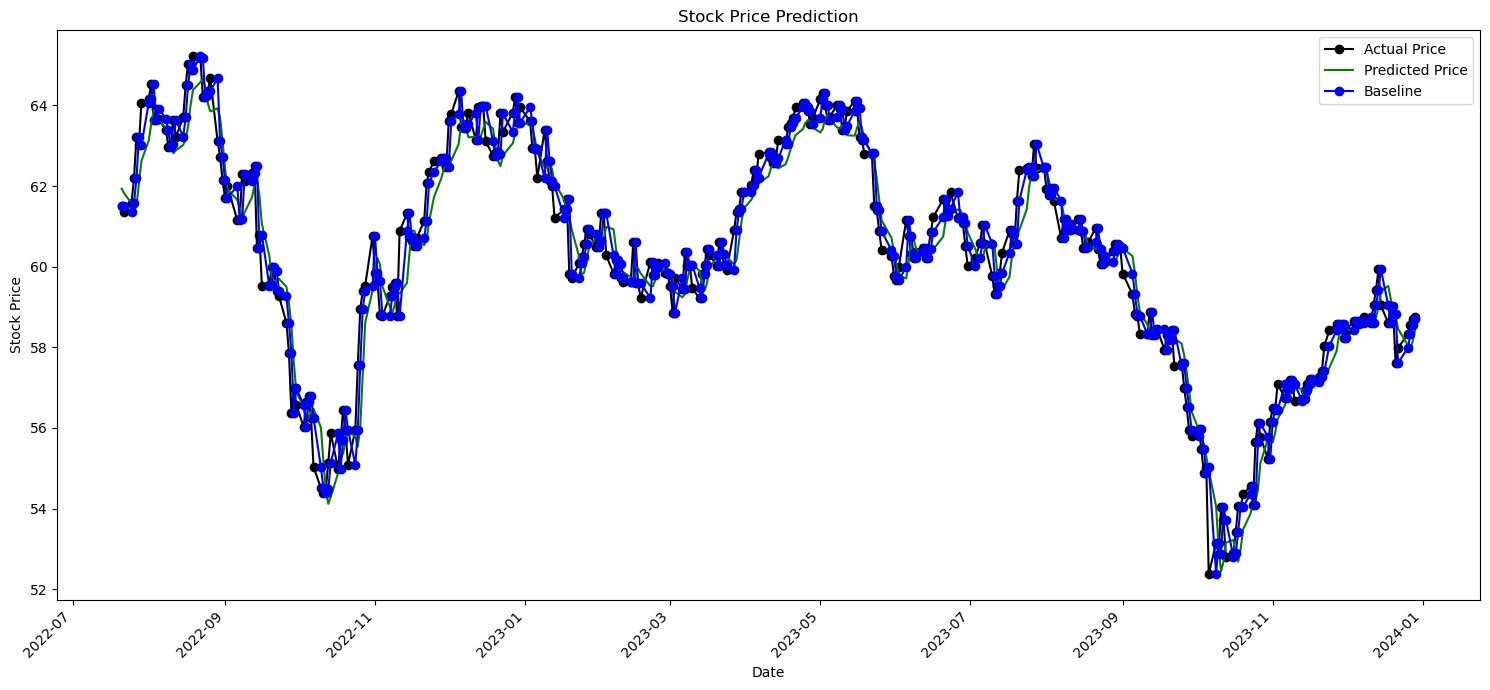

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.0012074525002390146
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
test_loss,▁
train_loss_epoch,▁████████████████████▇████▇█▇█
train_loss_step,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▄▄▁▁▅▅▁▂▂▆▂▂▂▂▂▂▇▇▇▂▂██
val_loss_epoch,█▅█▆▆▄▄▃▃▃▃▂▃▂▂▂▂▂▃▃▃▃▃▂▄▂▄▁█▁
val_loss_step,▁█▂▂▁▆▃▁▁▄▂▂▁▃▂▂▁▃▂▂▁▂▃▂▁▁▃▂▁▁▃▁▂▁▂▂▁▂▇▁
epoch,30
test_loss,0.00121
train_loss_epoch,0.00035
train_loss_step,0.00089


In [1]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import yfinance as yf
from pl_models import RNNModel, LSTMModel, GRUModel
from pl_config import stock_ticker, architecture, seq_length, start_date, end_date, num_epochs, learning_rate
from pl_config import wandb_config, model_config
import wandb
import os


class StockPredictionModule(pl.LightningModule):
    def __init__(self, model, scaler, train_loader, val_loader, test_loader, test_dates):
        super().__init__()
        self.model = model
        self.scaler = scaler
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.test_dates = test_dates
        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        return optimizer

    def training_step(self, batch, batch_idx):
        seqs, labels = batch
        y_pred = self(seqs)
        loss = self.criterion(y_pred, labels)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        seqs, labels = batch
        y_pred = self(seqs)
        loss = self.criterion(y_pred, labels)
        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        seqs, labels = batch
        y_pred = self(seqs)
        loss = self.criterion(y_pred, labels)
        self.log("test_loss", loss)
        return loss

    def on_test_epoch_end(self):
        predictions, actuals = [], []
        for seqs, labels in self.test_loader:
            seqs, labels = seqs.to(self.device), labels.to(self.device)
            output = self(seqs)
            predictions.extend(output.view(-1).tolist())
            actuals.extend(labels.view(-1).tolist())
        
        predictions = np.array(predictions)
        actuals = np.array(actuals)
        predictions_original_scale = list(self.scaler.inverse_transform(predictions.reshape(-1, 1)).flatten())
        actuals_original_scale = list(self.scaler.inverse_transform(actuals.reshape(-1, 1)).flatten())
        baseline_original_scale = [actuals_original_scale[0]] + actuals_original_scale[:-1]
        
        fig, ax = plt.subplots(figsize=(15, 7))
        ax.plot(self.test_dates, actuals_original_scale, label='Actual Price', color='black', linestyle='-', marker='o')
        ax.plot(self.test_dates, predictions_original_scale, label='Predicted Price', color='green', linestyle='-')
        ax.plot(self.test_dates, baseline_original_scale, label='Baseline', color='blue', linestyle='-', marker='o')
        ax.set_title('Stock Price Prediction')
        ax.set_xlabel('Date')
        ax.set_ylabel('Stock Price')
        ax.legend()
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
        plt.tight_layout()
        plt.plot()
        plt.show()
        
        filename = "plot.png"
        fig.savefig(filename)
        wandb.log({"Stock Price Prediction": wandb.Image(filename)})
        os.remove(filename)
        plt.close(fig)

        actuals_original_scale = np.array(actuals_original_scale)
        predictions_original_scale = np.array(predictions_original_scale)
        baseline_original_scale = np.array(baseline_original_scale)

        model_mse = mean_squared_error(actuals_original_scale, predictions_original_scale)
        model_rmse = np.sqrt(model_mse)
        model_mae = mean_absolute_error(actuals_original_scale, predictions_original_scale)
        model_r2 = r2_score(actuals_original_scale, predictions_original_scale)
        model_mape = np.mean(np.abs((actuals_original_scale - predictions_original_scale) / actuals_original_scale))
        
        baseline_mse = mean_squared_error(actuals_original_scale, baseline_original_scale)
        baseline_rmse = np.sqrt(baseline_mse)
        baseline_mae = mean_absolute_error(actuals_original_scale, baseline_original_scale)
        baseline_r2 = r2_score(actuals_original_scale, baseline_original_scale)
        baseline_mape = np.mean(np.abs((actuals_original_scale - baseline_original_scale) / (actuals_original_scale + 1e-8)))

        model_metrics = {
            "mse": model_mse,
            "rmse": model_rmse,
            "mae": model_mae,
            "mape": model_mape,
            "r2": model_r2,
        }

        baseline_metrics = {
            "mse": baseline_mse,
            "rmse": baseline_rmse,
            "mae": baseline_mae,
            "mape": baseline_mape,
            "r2": baseline_r2,
        }

        performance_metrics = {
            "mse": round((baseline_mse / model_mse - 1) * 100, 2),
            "rmse": round((baseline_rmse / model_rmse - 1) * 100, 2),
            "mae": round((baseline_mae / model_mae - 1) * 100, 2),
            "mape": round((baseline_mape / model_mape - 1) * 100, 2),
            "r2": round((model_r2 / baseline_r2 - 1) * 100, 2),
        }

        # Create a wandb Table
        metrics_table = wandb.Table(columns=["metric", "model", "baseline", "performance comparison [%]"])

        # Add data to the table
        for metric in model_metrics.keys():
            metrics_table.add_data(metric, model_metrics[metric], baseline_metrics[metric], performance_metrics[metric])

        # Log the table to wandb
        wandb.log({"metrics": metrics_table})


def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length-1):
        xs.append(data[i:(i+seq_length)])
        ys.append(data[i+seq_length])
    return np.array(xs), np.array(ys)


def load_data():
    stock_df = yf.download(stock_ticker, start=start_date, end=end_date)

    split_idx = int(len(stock_df) * 0.8) + seq_length
    train_df = stock_df.iloc[:split_idx]
    temp_df = stock_df.iloc[split_idx:]

    scaler = MinMaxScaler(feature_range=(-1, 1))
    train_normalized = scaler.fit_transform(train_df[['Close']].values.reshape(-1, 1))
    X_train, y_train = create_sequences(train_normalized, seq_length)

    temp_normalized = scaler.transform(temp_df[['Close']].values.reshape(-1, 1))
    X_temp, y_temp = create_sequences(temp_normalized, seq_length)

    split_idx_temp = len(y_temp) // 2
    X_val, X_test = X_temp[:split_idx_temp], X_temp[split_idx_temp:]
    y_val, y_test = y_temp[:split_idx_temp], y_temp[split_idx_temp:]

    # Calculate the test test_dates based on the length of the test set
    test_test_dates = stock_df.index[-(len(X_test) + seq_length):].tolist()
    test_test_dates = test_test_dates[seq_length:]  # Offset by seq_length because each sequence has seq_length preceding values

    train_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train)), batch_size=64, shuffle=False)
    val_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val)), batch_size=64, shuffle=False)
    test_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test)), batch_size=64, shuffle=False)
    
    return train_loader, val_loader, test_loader, scaler, test_test_dates


def main():

    wandb_logger = WandbLogger(project="RNN_single_step_forecasts", log_model="all", config=wandb_config)

    train_loader, val_loader, test_loader, scaler, test_dates = load_data()

    if architecture == "RNN":
        model = RNNModel(**model_config)
    elif architecture == "LSTM":
        model = LSTMModel(**model_config)
    elif architecture == "GRU":
        model = GRUModel(**model_config)
    else:
        raise ValueError("Unsupported architecture specified")

    module = StockPredictionModule(model=model, scaler=scaler, train_loader=train_loader, val_loader=val_loader, test_loader=test_loader, test_dates=test_dates)

    # Device agnostic initialization
    if torch.cuda.is_available():   # Check for GPU availability
        accelerator = "gpu"
        devices = 1
    elif hasattr(torch, 'has_mps') and torch.backends.mps.is_built():  # Check for MPS availability (Apple Silicon)
        accelerator = "mps"
        devices = 1
    else:
        accelerator = None  # Defaults to CPU
        devices = None  # Ignored for CPU

    trainer = Trainer(max_epochs=num_epochs, logger=wandb_logger, accelerator=accelerator, devices=devices, enable_checkpointing=True)
    trainer.fit(module, train_dataloaders=train_loader, val_dataloaders=val_loader)
    trainer.test(dataloaders=test_loader, ckpt_path="best")

    wandb.finish()


if __name__ == "__main__":
    main()

